In [42]:
import json
from collections import defaultdict, Counter
import pandas as pd
import joblib
import re
from datetime import datetime
import matplotlib.pyplot as plt

In [43]:
# Langkah 1: Baca Data JSON
with open('student_validations.json') as file:
    data = json.load(file)

# Ekstrak data yang relevan
table_data = data[2]['data']

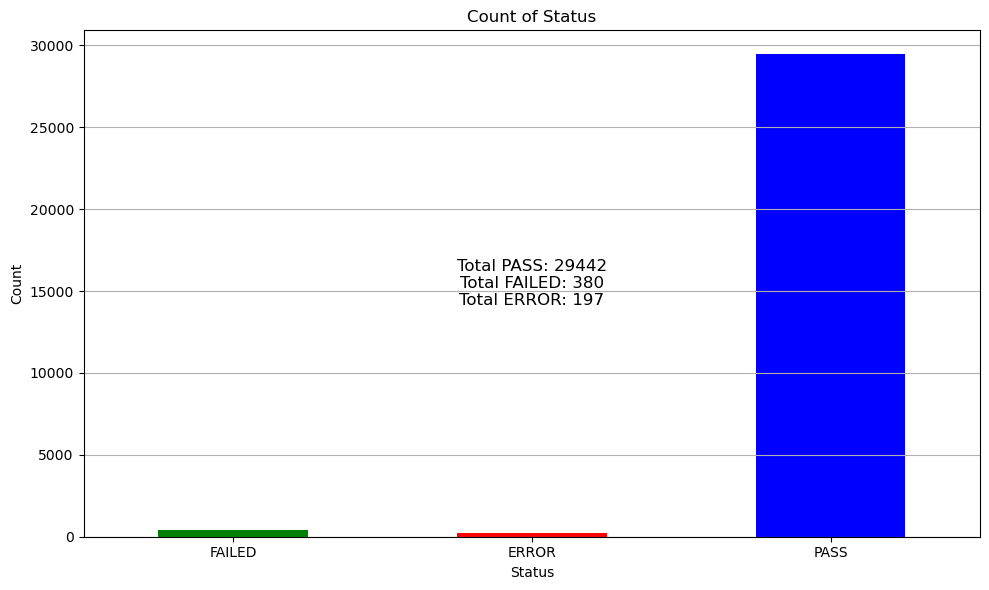

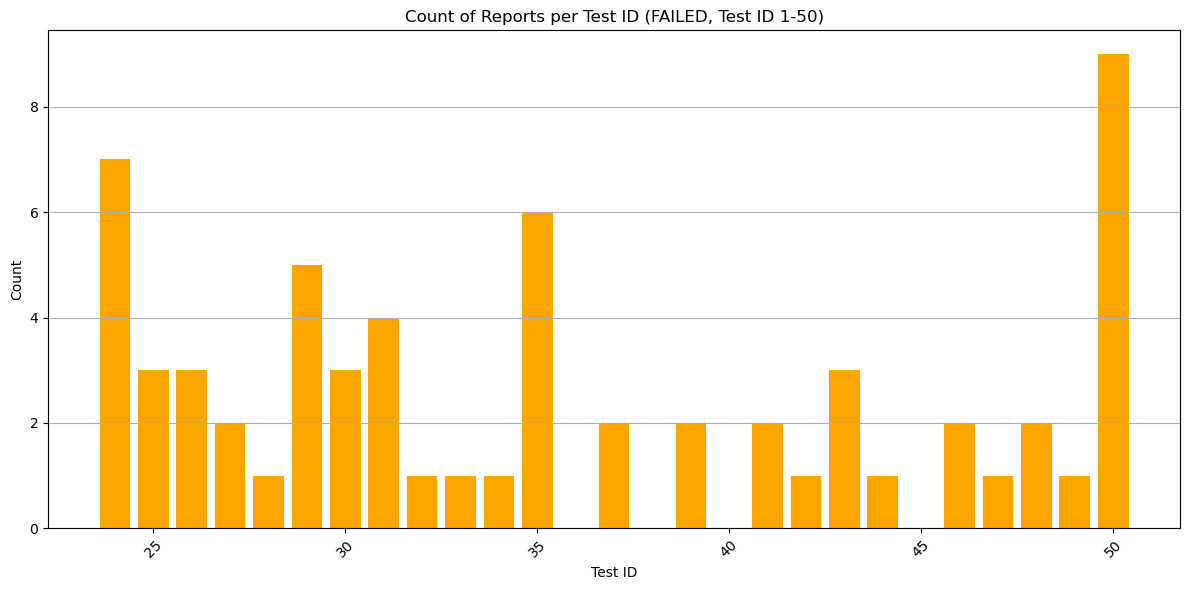

In [44]:
# Langkah 2: Ekstrak Informasi dan Hitung Frekuensi
report_counts = defaultdict(int)
first_occurrence = {}

for record in table_data:
    testid = int(record['testid'])
    status = record['status']
    report_lines = record['report'].split('\n')
    
    if status == 'FAILED':
        for line in report_lines:
            match = re.match(r'(\d+)\.\s*(.*)', line.strip())
            if match:
                number = int(match.group(1))
                check_part = match.group(2)
                key = (testid, number)
                if '-> FAILED' in check_part:
                    if key not in first_occurrence:
                        first_occurrence[key] = line.strip()
                    report_counts[key] += 1
    elif status == 'ERROR':
        error_report = record['report'].strip()
        error_key = (testid, 'ERROR')
        if error_key not in first_occurrence:
            first_occurrence[error_key] = error_report
        report_counts[error_key] += 1
    # Tidak memproses data dengan status 'PASS'

# Konversi hasil ke dalam DataFrame
rows = []
for key, count in report_counts.items():
    testid, number_or_status = key
    report = first_occurrence[key]
    if isinstance(number_or_status, int):
        rows.append((testid, 'FAILED', report, count))
    elif number_or_status == 'ERROR':
        rows.append((testid, 'ERROR', report, count))

report_df = pd.DataFrame(rows, columns=['testid', 'status', 'report', 'count'])

# Hitung jumlah PASS
pass_count = len(data[2]['data']) - report_df['status'].value_counts().sum()

# Contoh visualisasi menggunakan bar chart untuk menampilkan jumlah 'count' per 'status' (termasuk PASS)
plt.figure(figsize=(10, 6))
status_counts = report_df['status'].value_counts()
status_counts['PASS'] = pass_count  # Menambahkan jumlah PASS
status_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Count of Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Anotasi untuk menampilkan jumlah total PASS, FAILED, dan ERROR
total_counts = f"Total PASS: {pass_count}\nTotal FAILED: {status_counts['FAILED']}\nTotal ERROR: {status_counts['ERROR']}"
plt.annotate(total_counts, xy=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()

# Visualisasi menggunakan histogram untuk menampilkan distribusi 'count' per 'testid' (Test ID 1-50)
plt.figure(figsize=(12, 6))
filtered_report_df = report_df[(report_df['testid'] >= 1) & (report_df['testid'] <= 50) & (report_df['status'] == 'FAILED')]
testid_counts = Counter(filtered_report_df['testid'])
testids = list(testid_counts.keys())
counts = list(testid_counts.values())
plt.bar(testids, counts, color='orange')
plt.title('Count of Reports per Test ID (FAILED, Test ID 1-50)')
plt.xlabel('Test ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [45]:
## Langkah 3: Urutkan hasil berdasarkan testid dan count terbanyak
report_df_sorted = report_df.sort_values(by=['testid', 'count'], ascending=[True, False])

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Simpan DataFrame ke CSV
csv_filename = f'simplified_report_counts_{timestamp}.csv'
report_df_sorted.to_csv(csv_filename, index=False)

# Simpan DataFrame ke JSON
json_filename = f'simplified_report_counts_{timestamp}.json'
report_df_sorted.to_json(json_filename, orient='records')

# Simpan model yang dilatih (misal: DecisionTreeClassifier)
# Latih ulang model jika diperlukan
X = report_df[['testid', 'count']]
y = report_df['report']

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X, y)

# Simpan model ke file pkl
pkl_filename = f'simplified_report_model_{timestamp}.pkl'
joblib.dump(model, pkl_filename)

print(f"Proses selesai, file '{csv_filename}', dan '{pkl_filename}' telah dibuat.")

Proses selesai, file 'simplified_report_counts_20240715_191521.csv', dan 'simplified_report_model_20240715_191521.pkl' telah dibuat.


In [46]:
import sklearn
print(sklearn.__version__)  # Untuk memeriksa versi yang sedang digunakan


1.3.0


In [55]:
import json
import joblib
import pandas as pd

# Load the JSON data for new observations
with open('simplified_report_counts_20240715_135539.json') as file:
    new_data = json.load(file)

# Assuming 'new_data' is a list of dictionaries, convert it to a DataFrame
new_df = pd.DataFrame(new_data)

# Load the trained model from the .pkl file
model_filename = 'simplified_report_model_20240715_191521.pkl'
model = joblib.load(model_filename)

# check accuracy of the model
accuracy = model.score(new_df[['testid', 'count']], new_df['report'])
print(f"Model accuracy: {accuracy:.2%}")


Model accuracy: 37.29%
